In [3]:
%matplotlib inline
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gp
from shapely import wkt, wkb
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, MultiLineString
import contextily as ctx

# helper functions
sys.path.insert(0, 'helper_functions/')

# paths + files
PATH_TO_DATA = '/home/diederik/ams/pyprojects/geospatial_analysis/data/'
AIR_BNB_FILE_MUNGED = 'airbnb_munged.csv' # munged version 
STADSDELEN = 'sd.csv'
BUURT_COMBINATIES = 'buurt_combi.csv'
BUURT = 'buurt.csv'

In [4]:
# load airbnb data from csv
crs_initial = {'init': 'epsg:28992'}
converters = {'geometry': lambda x: wkt.loads(x), 'sd_id': str, 'b_id': str}
# airbnb
df= (pd.read_csv(PATH_TO_DATA + AIR_BNB_FILE_MUNGED, converters=converters, 
                 parse_dates=['last_review']))
df = gp.GeoDataFrame(df, crs=crs_initial, geometry='geometry')
# stadsdelen
sd = pd.read_csv(PATH_TO_DATA + STADSDELEN, converters=converters)
sd = gp.GeoDataFrame(sd, crs=crs_initial, geometry='geometry')
# buurtcombinaties
# bc = pd.read_csv(PATH_TO_DATA + BUURT_COMBINATIES, converters=converters)
# bc = gp.GeoDataFrame(bc, crs=crs_initial, geometry='geometry')
# buurten
buurt = pd.read_csv(PATH_TO_DATA + BUURT, converters=converters)
buurt = gp.GeoDataFrame(buurt, crs=crs_initial, geometry='geometry')

### 1) Where are the most expensive apartments located

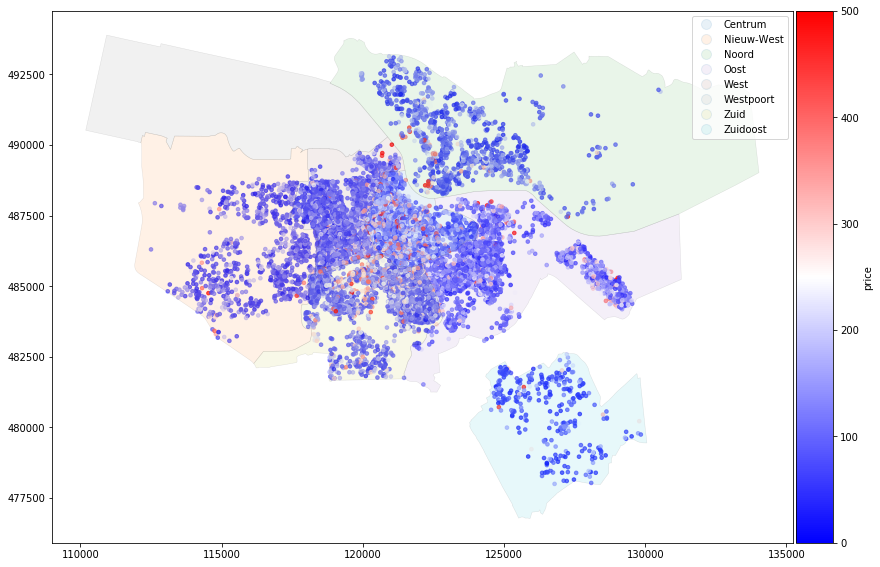

In [8]:
# hell of a job to get the adjusted colorbar size (Argghh)
from mpl_toolkits.axes_grid1 import make_axes_locatable
style_kwds = {'markersize': 13,'alpha': .7}
vmin, vmax = 0, 500

fig, ax= plt.subplots(figsize=[14,14])
ax = df.plot(column='price', ax=ax, cmap='bwr', **style_kwds)

sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# fake up the array of the scalar mappable. 
sm._A = []
plt.colorbar(sm, cax, label='price')
# adjust colorbar tick formatting
cb = ax.get_figure().get_axes()[1]
#cb.set_ticks(['€{0:.0f}'.format(ytick) for ytick in yticks]);

style_kwd_sd = {'alpha': .1, 'linewidth': .5, 'edgecolor': 'k'}
sd.plot(ax=ax, **style_kwd_sd, column='sd_name', legend=True)

hmm not the best map. Let's grab a basemap using contextily, a package to provide basemaps for data, best used for data in webmercator (epsg:3857 or 4326) or raw WGS lon-lat coordinates.

Here we grab the basemap images for the total_bounds of our study area at a given zoom level, also specifying a different tile server from the default: the Stamen Maps toner-lite tiles for its aesthetics.

In [115]:
# convert to webmercator
df2 = df.to_crs(epsg=3857)
buurt = buurt.to_crs(epsg=3857)

In [116]:
basemap, bounds = ctx.bounds2img(*df2.total_bounds, zoom=10, 
                                 url='http://tile.stamen.com/toner-lite/tileZ/tileX/tileY.png')

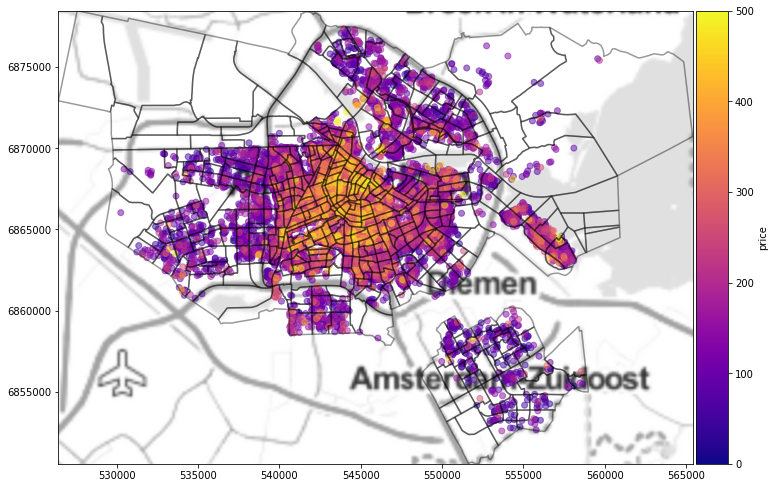

In [117]:
f = plt.figure(figsize=(12,12))
ax = plt.gca()
buurt.boundary.plot(color='k', ax=ax, alpha=.4)
ax.imshow(basemap, extent=bounds, interpolation='gaussian', alpha= .8)
ax.axis(buurt.total_bounds[np.asarray([0,2,1,3])])
df2.sort_values('price').plot('price', ax=ax, marker='o', cmap='plasma', alpha=.5)

sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# fake up the array of the scalar mappable. 
sm._A = []
plt.colorbar(sm, cax, label='price')

In [118]:
district_price = df.groupby(['b_name']).price.median().to_frame()
district_price.sort_values(by='price', ascending=False)[:5]

,price
b_name,
Rieteiland Oost,295.0
Hiltonbuurt,275.0
Holendrecht West,270.0
Minervabuurt Noord,262.5
NDSM terrein,250.0


In [119]:
buurt = buurt.merge(district_price,
                    left_on='b_name', 
                    right_index=True, how='left')
buurt = buurt.rename(columns=dict(price='median_price'))

The Quantiles scheme is one map classification method that GeoPanda includes, which are in turn based on PySAL

array([ 526403.03595246,  565409.75197688, 6850580.04617035,
       6878445.769546  ])

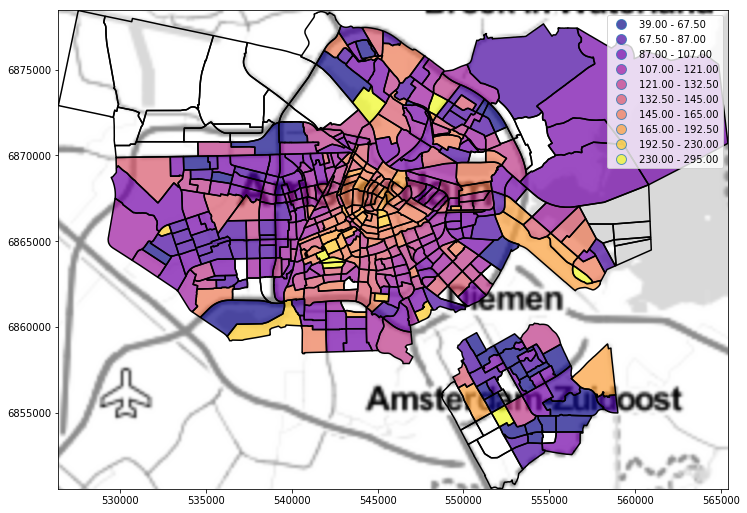

In [121]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
buurt.boundary.plot(color='black', ax=ax)
buurt.dropna().plot(column= 'median_price', scheme='Fisher_Jenks', k=10, legend=True,
                    cmap='plasma', alpha=.7, ax=ax)
#basemap of the area
ax.imshow(basemap, extent=bounds, interpolation='gaussian')
ax.axis(buurt.total_bounds[np.asarray([0,2,1,3])])

### adjecency graphs represent how neighbourdhood polygons relate to each other

The **queen contiguitiy weight** is commonly-used reflecting adjacency relationships as a binary indicator variable denoting whether or not a polygon shares an edge/ vertex with another polygon. See how this works focusing on the neighborhoods in Stadsdeel 'West'

Queen contiguigy requires either an edge or a vertex and **Rook contiguity** requires only shared edges. (considers observations as neighboring only when they share an **edge**)

In [156]:
# buurt = buurt.to_crs(epsg=28992)
# sd= sd.to_crs(epsg=28992)

In [14]:
# join the Stadsdelen to buurten
buurt_enriched = gp.sjoin(buurt, sd, how='inner', op = 'intersects')
buurt_west = buurt_enriched[buurt_enriched.sd_name == 'West'].reset_index()

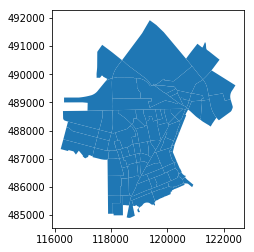

In [15]:
buurt_west.plot()

In [46]:
import libpysal.api as lp
Qneighbs = lp.Queen.from_dataframe(buurt_west) # construct Queen adjacency graph
Rneighbs = lp.Rook.from_dataframe(buurt_west) # construct Queen adjacency graph

In [50]:
Qneighbs[obs_].keys()

dict_keys([48, 4, 6, 47])

In [55]:
obs_ = 5
print ('Queen contiguity {}th observation neighbors {} and their weights {}'.\
       format(obs_, Qneighbs[obs_].keys(), Qneighbs[obs_].values())) 
print ('Rook contiguity {}th observation neighbors {} and their weights {}'.\
       format(obs_, Rneighbs[obs_].keys(), Rneighbs[obs_].values())) 

Queen contiguity 5th observation neighbors dict_keys([48, 4, 6, 47]) and their weights dict_values([1.0, 1.0, 1.0, 1.0])
Rook contiguity 5th observation neighbors dict_keys([4, 6, 47]) and their weights dict_values([1.0, 1.0, 1.0])


The weights dictionary and the `buurt` dataframe use the same index. By combining the weight dictionary's index and its neighbors' indices together in one list called `focal_neighbors` , we can view the observation (3rd) and its neighbors in the dataframe by putting. 

[5, 4, 6, 47]


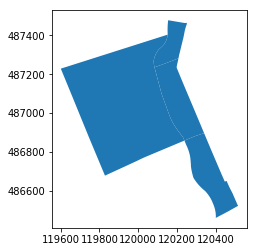

In [56]:
focal_neighbors = [obs_]
focal_neighbors.extend(Rneighbs.neighbors[obs_]) # extend focal with its neighbours
print(focal_neighbors)
# plot the neighbours
buurt_west.loc[focal_neighbors].plot();

In [57]:
# the neighourhoods adjacent to the focal area 
buurt_west.loc[focal_neighbors, :]

,index,geometry,b_id,b_name,index_right,sd_code,sd_id,sd_name
5,74,"POLYGON ((120084.0516624 487235.7249929, 12010...",03630000000506,Groenmarktkadebuurt,4,E,03630011872036,West
4,72,"POLYGON ((120250.7444797 487465.1179719, 12025...",03630000000503,Marnixbuurt Midden,4,E,03630011872036,West
6,75,"POLYGON ((120400.1801656 486458.6363454, 12040...",03630000000507,Marnixbuurt Zuid,4,E,03630011872036,West
47,191,"POLYGON ((119828.4968949 486676.896265, 119746...",03630000000862,Da Costabuurt Noord,4,E,03630011872036,West


A full, dense matrix with all pairwise relationships is created with `.full` method, or when `pysal.full` is called on a weights object:

In [20]:
Wmatrix, ids = Qneighbs.full()
Wmatrix

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [21]:
n_neighbors = Wmatrix.sum(axis=1) # how many neighbors each region has

In [26]:
n_neighbors

array([ 5.,  3.,  5.,  4.,  4.,  4.,  5.,  4.,  7.,  4.,  6.,  4.,  4.,
        3.,  5.,  4.,  5.,  5.,  5.,  4.,  8.,  7.,  5.,  5.,  7.,  5.,
        9.,  6.,  8.,  9.,  6.,  4.,  7.,  8.,  9.,  6.,  7.,  5., 12.,
        7.,  5.,  4.,  6.,  6.,  6.,  8.,  8.,  9.,  7.,  5.,  6.,  6.,
        5.,  6.,  7.,  6.,  7.,  7.,  6.,  8.,  8.,  7.,  7.,  6.,  6.,
        6.,  7.,  6.,  7.,  7.,  5.,  6.,  4.,  6.,  3.,  4.,  4.,  5.,
        5.,  3.,  3.,  3.,  4.,  6.,  5.,  5.,  3.,  3.,  9.,  5.,  6.,
        7.,  7.,  7.,  9.,  8.,  7.,  7.])

### plot the adjacency matrices

- the matplotlib way and using the Queen object plotting method

In [30]:
listarray = []
for c in buurt_west.geometry.centroid:
    listarray.append([c.x, c.y])
centroid_array = np.array(listarray)

print (centroid_array[:3])

[[120662.29552453 488685.7654015 ]
 [120714.26590705 486172.47803208]
 [121027.44138499 488781.54543539]]


[Text(0.5,1,'Rook Adjacency matrix')]

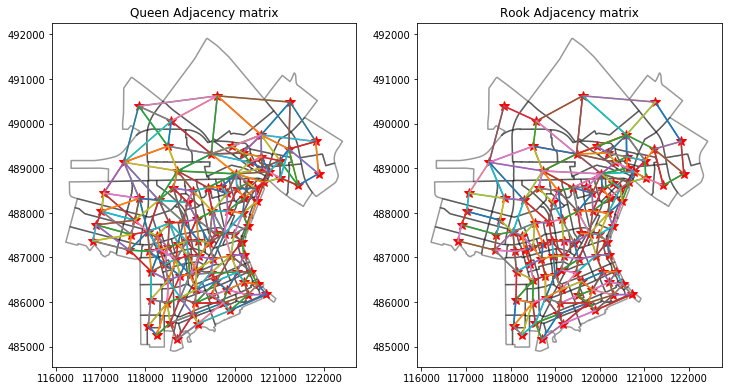

In [61]:
fig, ax = plt.subplots(1, 2, figsize=[12,10])
# Queen
ax[0].plot(centroid_array[:, 0], centroid_array[:, 1], '*', ms=10, c='red')
buurt_west.boundary.plot(color='k', ax=ax[0], alpha=.4)
for i, neighs in Qneighbs.neighbors.items():
    origin = centroid_array[i]
    for neigh in neighs:
        segment  = centroid_array[[i, neigh]]
        ax[0].plot(segment[:, 0], segment[:, 1], '-')
# Rook
ax[1].plot(centroid_array[:, 0], centroid_array[:, 1], '*', ms=10, c='red')
buurt_west.boundary.plot(color='k', ax=ax[1], alpha=.4)
for i, neighs in Rneighbs.neighbors.items():
    origin = centroid_array[i]
    for neigh in neighs:
        segment  = centroid_array[[i, neigh]]
        ax[1].plot(segment[:, 0], segment[:, 1], '-')
ax[0].set(title='Queen Adjacency matrix')
ax[1].set(title='Rook Adjacency matrix')

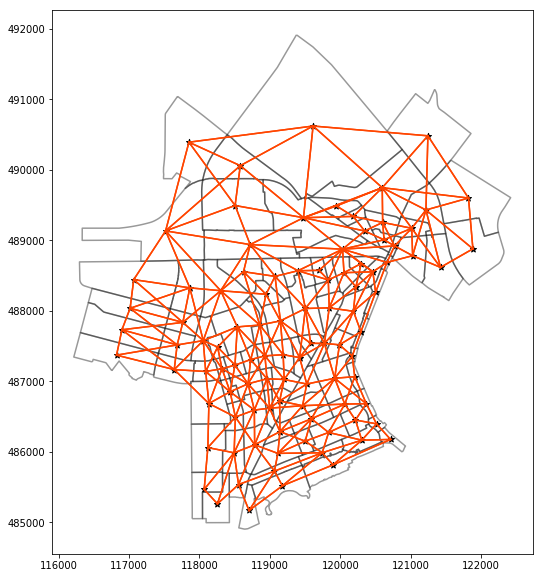

In [45]:
# There are no easier to use plotting methods like calling plot on the Queen object
fig, ax = plt.subplots(figsize=[12,10])
buurt_west.boundary.plot(color='k', ax=ax, alpha=.4)
Qneighbs.plot(buurt_west, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*', s=40), ax=ax);